# TASK1 . Data Quality

#### a. Example of Poor Quality Structured Data
We consider a securities trading dataset where:
- *Timestamp* field mixes ISO 8601 format (`2023-08-15T09:30:00Z`) and local time (`Aug 15, 2023 9:30 AM EST`)
- *Asset identifiers* inconsistently use tickers (`AAPL`), ISINs (`US0378331005`), and internal codes (`EQ123`)
- *Transaction volumes* contain negative values

#### b. Recognizing Poor Quality in Structured Data
We identify three critical failures of data quality principles:
1. **Lack of Validity**: Negative share volumes violate domain rules
2. **Inconsistent Formatting**: Timestamp heterogeneity breaches the consistency requirement for time-series analysis.
3. **Ambiguous Identifier Schema**: Mixed asset identification methods compromise uniqueness and traceability, preventing accurate instrument mapping.

#### c. Example of Poor Quality Unstructured Data
Through the course about Social Media Data , we could observe financial social media data exhibiting:
- Tweets truncated mid-sentence due to API limitations
- Duplicate or reposted posts from bot accounts (identical content posted or reposted  ≥5 times/minute)
- Irrelevant content (e.g., meme images without financial context in a market discussion corpus)

#### d. Assessing Poor Quality in Unstructured Data
We would evaluate failures through these lenses:
1. **Incompleteness**: Truncated tweets lose critical sentiment signals, violating the *comprehensiveness* requirement for NLP modeling.
2. **Non-Uniqueness**: Bot-generated duplicates artificially inflate term frequencies, distorting *representational accuracy* of market sentiment.
3. **Contextual Irrelevance**: Non-financial content introduces noise that breaches *fitness-for-purpose* in trading signal extraction.
4. **Unverifiable Provenance**: Absence of user verification metadata undermines *auditability*, a core quality attribute for regulatory use cases.


# Task 2
We retrieved U.S. Treasury yield data from the Federal Reserve Economic Data (FRED) platform using the fredapi.
Specifically, we collected yield curves from January 2024 to June 2025, a recent 18-month period that:

* Covers a wide range of market conditions, including inflation and rate decisions.

* Provides sufficient data points for robust model fitting and comparison.

* Matches the project's requirement of including short- to long-term maturities (from 1 month to 30 years).

The dataset includes maturities: 1M, 3M, 6M, 1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, and 30Y.
Missing values (e.g., holidays) were left intact to preserve data integrity and may be dropped during fitting.



In [21]:
'''
a. Pick government securities from a country. The country selected should be one
of the countries from your group so that you can fit a Nelson-Siegel model.

b. Be sure to pick maturities ranging from short-term to long-term (e.g. 6 month
maturity to 20 or 30 year maturities).
'''
import pandas as pd
df = pd.read_csv('data/yields_2024_2025-06.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df_clean = df.dropna()
df_clean

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
2024-01-02,5.55,5.46,5.24,4.80,4.33,4.09,3.93,3.95,3.95,4.25,4.08
2024-01-03,5.54,5.48,5.25,4.81,4.33,4.07,3.90,3.92,3.91,4.21,4.05
2024-01-04,5.56,5.48,5.25,4.85,4.38,4.14,3.97,3.99,3.99,4.30,4.13
2024-01-05,5.54,5.47,5.24,4.84,4.40,4.17,4.02,4.04,4.05,4.37,4.21
2024-01-08,5.54,5.49,5.24,4.82,4.36,4.11,3.97,3.99,4.01,4.33,4.17
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,4.21,4.38,4.27,3.99,3.75,3.75,3.86,4.06,4.30,4.83,4.83
2025-06-25,4.21,4.38,4.26,3.99,3.74,3.74,3.83,4.05,4.29,4.83,4.83
2025-06-26,4.11,4.39,4.26,3.96,3.70,3.68,3.79,4.00,4.26,4.81,4.81
2025-06-27,4.19,4.39,4.26,3.97,3.73,3.72,3.83,4.03,4.29,4.85,4.85


Nelson–Siegel fitted parameters:
  β0 (Level)    = 5.1948
  β1 (Slope)    = -0.7140
  β2 (Curvature)= -3.8303
  τ (Decay rate)= 2.2120


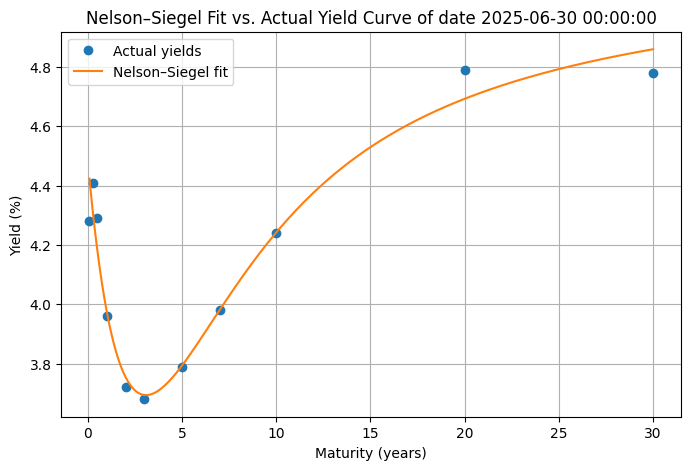

In [22]:
'''
c. Fit a Nelson–Siegel model to the latest yield curve from our DataFrame.
'''

import matplotlib.pyplot as plt
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import numpy as np
maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])

yields_latest = df_clean.iloc[-1].values

curve, status = calibrate_ns_ols(maturities, yields_latest, tau0=1.0)
assert status.success, "Nelson–Siegel calibration failed"

print("Nelson–Siegel fitted parameters:")
print(f"  β0 (Level)    = {curve.beta0:.4f}")
print(f"  β1 (Slope)    = {curve.beta1:.4f}")
print(f"  β2 (Curvature)= {curve.beta2:.4f}")
print(f"  τ (Decay rate)= {curve.tau:.4f}")

t_hat = np.linspace(0.0833, 30, 300)
y_hat = curve(t_hat)

plt.figure(figsize=(8, 5))
plt.plot(maturities, yields_latest, 'o', label='Actual yields')
plt.plot(t_hat, y_hat,    '-', label='Nelson–Siegel fit')
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title(f"Nelson–Siegel Fit vs. Actual Yield Curve of date {df_clean.index[-1]}")
plt.legend()
plt.grid(True)
plt.show()

 Figure X: Nelson–Siegel Fit vs. Actual Yield Curve on 2025-06-30
- **Level (β0 = 5.1948%)**
  The model matches the long end (10Y–30Y) almost perfectly, indicating that the market’s long-run average yield is about 5.2%.

- **Slope (β1 = –0.7140%)**
  A negative β1 creates an initial downward tilt: short-term yields (1M–6M) sit above the mid-curve trough. This reflects Fed policy in mid-2025—after aggressive hikes in 2022–24, overnight rates remain elevated before markets anticipate cuts further out.

- **Curvature (β2 = –3.8303%) & Decay rate (τ = 2.2120 years)**
  The pronounced “hump” around 2–5 year maturities is captured by a large negative β2 and τ≈2.2. That hump signals investor uncertainty: they demand higher compensation for medium-term risk—likely due to mixed economic signals (sticky core inflation vs. softening headline CPI).

- **Growth vs. Recession Concerns**
  A gently upward long end (10–30 year) implies no imminent long-term recession fears—markets still price modest growth out to 2030. Yet the inverted short-term (slope < 0 at 1–2 year) underscores recession risks within the next 18 months.



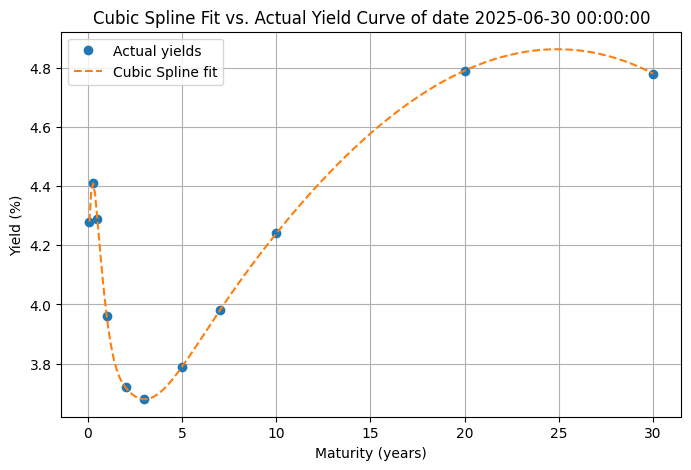

In [23]:
from scipy.interpolate import CubicSpline

'''
d. Fit a Cubic–Spline model to the latest yield curve from our DataFrame.
'''

cs = CubicSpline(maturities, yields_latest)

t_hat = np.linspace(maturities.min(), maturities.max(), 300)
cs_fit = cs(t_hat)

plt.figure(figsize=(8, 5))
plt.plot(maturities, yields_latest, 'o', label='Actual yields')
plt.plot(t_hat, cs_fit,   '--', label='Cubic Spline fit')
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title(f"Cubic Spline Fit vs. Actual Yield Curve of date {df_clean.index[-1]}")
plt.legend()
plt.grid(True)
plt.show()

 Figure Y: Cubic Spline Fit vs. Actual Yield Curve on 2025-06-30

- **Exact interpolation at knot points**
  The spline curve passes through every observed yield (1M, 3M, …, 30Y) with zero residuals, by construction.

- **Short-term oscillation**
  Between 1M and 3M, the curve shows a sharp spike and drop—an artifact of high flexibility when data are sparse, indicating potential over-fitting.

- **Smooth mid-to-long term trend**
  From 5Y through 20Y, the spline smoothly rises in line with market yields. A slight hump near 25Y and mild downturn at 30Y reflect boundary behavior rather than economic drivers.


Fit comparison (MSE):
Nelson–Siegel MSE = 0.005267
Cubic–Spline MSE  = 0.000000



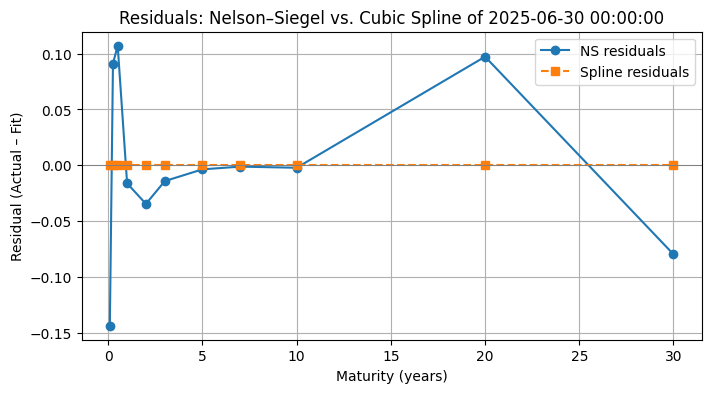

In [24]:
'''
e. Compare the Nelson–Siegel and Cubic–Spline models in terms of:
   1) Fit (MSE on the original maturities)
   2) Interpretation of each model

f. Specify and interpret the NS model parameters at their individual “factor” level.
'''
ns_at_nodes = curve(maturities)
cs_at_nodes = cs(maturities)
mse_ns = np.mean((yields_latest - ns_at_nodes)**2)
mse_cs = np.mean((yields_latest - cs_at_nodes)**2)

print(f"Fit comparison (MSE):")
print(f"Nelson–Siegel MSE = {mse_ns:.6f}")
print(f"Cubic–Spline MSE  = {mse_cs:.6f}\n")

# Visual overlay of residuals for quick sanity check
res_ns = yields_latest - ns_at_nodes
res_cs = yields_latest - cs_at_nodes

plt.figure(figsize=(8,4))
plt.plot(maturities, res_ns, 'o-', label='NS residuals')
plt.plot(maturities, res_cs, 's--', label='Spline residuals')
plt.axhline(0, color='gray', linewidth=0.7)
plt.xlabel("Maturity (years)")
plt.ylabel("Residual (Actual – Fit)")
plt.title(f"Residuals: Nelson–Siegel vs. Cubic Spline of {df_clean.index[-1]}")
plt.legend()
plt.grid(True)
plt.show()

Nelson–Siegel parameter interpretations:
* β0 (Level)    = 5.1948  ← long-run average yield (parallel shift)
* β1 (Slope)    = -0.7140  ← short-term vs long-term slope
* β2 (Curvature)= -3.8303  ← hump or dip in the mid-term segment
* τ (Decay rate)= 2.2120    ← maturity scale of the hump (years)

Cubic–Spline interpretation:
* No global factors; each sub-interval is fit by its own cubic polynomial.
* Guarantees an exact pass through every data point, but parameters lack a simple financial meaning.
* Very flexible locally, but can introduce unwanted oscillations between nodes.


### g. Ethical considerations of smoothing with Nelson–Siegel:

In Module 2 Lesson 4 we noted that smoothing becomes unethical if it hides
meaningful data features or is used to mislead stakeholders. The Nelson–Siegel model does apply
a smooth, parametric curve to discrete yield observations, but:

*  It preserves all major yield‐curve characteristics (level, slope, curvature)via transparent parameters (β0, β1, β2, τ).
*  It is a widely accepted industry standard for yield‐curve modeling and forecasting—any assumptions (e.g. parametric form, choice of τ) are fullydocumented.
*  It does **not** fabricate data points or artificially suppress volatility,
  rather, it provides a parsimonious summary of the curve’s shape.
Therefore, **Nelson–Siegel smoothing is not inherently unethical**—so long as the
model’s limitations are disclosed, and the fit is not used to mask true market
dynamics or misrepresent risk. Unethical smoothing would occur only if one
intentionally altered parameters or omitted data to suit a desired narrative.
